In [ ]:
!pip install git+https://github.com/SberProcessMining/Sber_Process_Mining.git
!pip install -U matplotlib
!pip install pm4py
#!pip install pomegranate
!pip install scikit-network

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Drill planner/Code')
sys.path.append('/content/drive/MyDrive/Drill planner/Code/Next operation prediction')

In [7]:
import sberpm
import pandas as pd
from sberpm.miners import SimpleMiner,CausalMiner, HeuMiner,AlphaPlusMiner, AlphaMiner, InductiveMiner
from sberpm.miners._abstract_miner import AbstractMiner
%matplotlib inline
from sberpm.visual import GraphvizPainter
import matplotlib.pyplot as plt
from sberpm import DataHolder
import networkx as nx
from sberpm.metrics import ActivityMetric, TransitionMetric, IdMetric, TraceMetric, UserMetric,TokenReplay
import numpy as np
import pm4py
#import pomegranate
from Drill_planner import DrillPlaner, nx_graph, GraphMiner, DrillGraphMiner
import sknetwork
from IPython.display import SVG
import missingno as msno
import seaborn as sns

In [11]:
dataset = pd.read_excel('/content/drive/MyDrive/Drill planner/Data/Dataset2.xlsx')

In [31]:
dataset['Operation code'] = dataset['Operation code'].astype(int)

def codes_changer(dataset, replacement_target, lists_to_replace, replacements):
  for l,r in zip(lists_to_replace, replacements):
    dataset[replacement_target].replace(l, r, inplace = True)

def operation_lag(dataset, code_column, lag,next_operation=False):
  df = np.zeros_like(dataset[code_column].values)
  df[lag:] = dataset[code_column].values[:-lag]
  if next_operation:
    df[:-lag] = dataset[code_column].values[lag:]
  return df

dataset['One_lag'] = operation_lag(dataset,['Operation code'],1)
dataset['Two_lag'] = operation_lag(dataset,['Operation code'],2)
dataset['Three_lag'] = operation_lag(dataset,['Operation code'],3)
#dataset['Four_lag'] = operation_lag(dataset,['Operation code'],4)
#dataset['Five_lag'] = operation_lag(dataset,['Operation code'],5)


codes_changer(dataset, 'Operation code', [[306, 307,308,309]], [310])
codes_changer(dataset, 'Operation code', [[301,302,303,304]], [305])
codes_changer(dataset, 'Operation code', [[315,316,330,331]], [348])
codes_changer(dataset, 'Operation code', [[317,318,332,333]], [347])


dataset['Next_operation'] = operation_lag(dataset,['Operation code'],1,next_operation=True)

In [78]:
burek = dataset[dataset['Phase'] == 'БУРЭК']
burek['Operation code'] = burek['Operation code'].astype(int)
data_holder = DataHolder(data=burek, 
                         id_column='Well number', 
                         activity_column='Operation code', 
                         start_timestamp_column='Timestamp', 
                         time_format='%Y.%m.%d')

#pd.set_option("max_rows",1000)
#burek

In [110]:
graph_planner = DrillGraphMiner(burek, 'Time, h (in grains)', 'Operation code')

In [111]:
DFG = graph_planner.to_dfg()

In [112]:
a = nx.bellman_ford_path(DFG, source=201, target='endevent', weight = "weight")

In [113]:
a

[201, 425, 310, 'endevent']

In [114]:
def next_operations(DFG, current_event):
  #Bellman-Ford shortest; precaution against ncycles
    a = nx.bellman_ford_path(DFG, current_event, target='endevent', weight = "weight")
    return a[1]


In [115]:
from networkx.exception import NodeNotFound
pred = []
for i in burek['Operation code']:
  try:
    next_oper = next_operations(DFG,i)
    pred.append(next_oper)
  except NodeNotFound:
    pred.append(0)

In [116]:
sum(1 for x,y in zip(pred,burek['Next_operation']) if x == y) / len(a)

31.75

In [117]:
def graph_metric(DFG,code1,code2):
  gen = nx.bellman_ford_path(DFG, code1, code2,weight="weight")
  weight = nx.path_weight(DFG,gen,weight="weight")
  return weight

def path_metric(DFG,path):
  a = []
  for i in path:
    b = graph_metric(DFG,i,path[-1])
    a.append(b)
  return a
    


In [74]:
graph_metric(DFG,201,'endevent')

8.0000000001

In [118]:
path_metric(DFG,a)

[8.0000000001, 7.7500000001, 4.5000000001, 0]

In [119]:
#THE IDEA OF HOW TO PROCEEED
#1. FIT AN AUTOREGRESSIVE MODEL
#2. PREDICT NEXT DISTANCE
#3. LOOP OVER ALL NODES, COMPUTE DISTANCES TO LAST KNOWN NODE, PICK CLOSEST TO OUTPUT OF 2.

In [120]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 1)

In [121]:
import statsmodels.tsa.statespace.sarimax
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [122]:
model = statsmodels.tsa.statespace.sarimax.SARIMAX(path_metric(DFG,a), order = (2,0,0))

In [123]:
example = model.fit()

In [124]:
example.forecast()

array([-4.48085999])

In [125]:
def ARIMA_pred(dist, graph, source):
  ex_list = []
  for nodes in list(graph.nodes):
    try:
      ex_list.append(nx.shortest_path_length(graph, source,nodes, weight = 'weight', method = 'bellman-ford'))
    except:
      ex_list.append(np.infty)
  ex_list = np.abs((np.array(ex_list) - np.abs(dist)))
  return list(graph.nodes)[np.argmin(ex_list)]

In [129]:
ARIMA_pred(example.forecast()[0], DFG, 201)

213

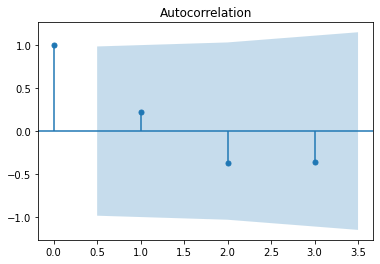

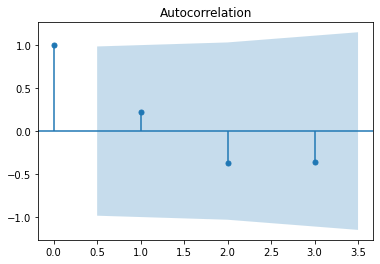

In [127]:
plot_acf(np.array(path_metric(DFG,a)))

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


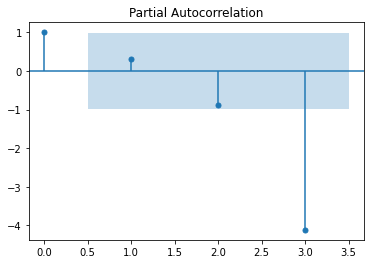

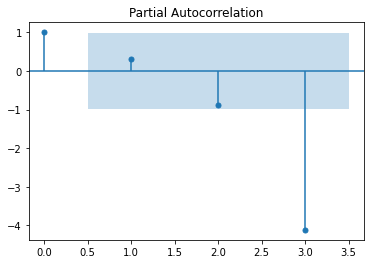

In [128]:
plot_pacf(np.array(path_metric(DFG,a)))